# Figure 10 - Example transit times by water mass class. 

Import libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import gsw
from scipy import stats
import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs

from dask.distributed import Client
import memory_profiler

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
from pathlib import Path
# in jupyter (labnotebook), based on notebook path
module_path = str(Path.cwd().parents[0] )
if module_path not in sys.path:
    sys.path.append(module_path)
import custom_functions as cf

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 18,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33159,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 18
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:42881,Total threads: 3
Dashboard: /proxy/36287/status,Memory: 30.00 GiB
Nanny: tcp://127.0.0.1:37193,


### Define plotting functions.

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# function to make sector map boundary path
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

# these lon/lat arrays are NOT masked
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

def insert_map(axes, projection, width, height, midlon, dlon, minlat, maxlat, bbox=()):
    ''''
    width/height specified as e.g. "60%"
    '''
    midlat = (minlat + maxlat)/2
    if projection is 'Mercator':
        axins = inset_axes(axes, width=width, height=height, loc="upper right", 
        axes_class=cartopy.mpl.geoaxes.GeoAxes, axes_kwargs=dict(map_projection=ccrs.Mercator(central_longitude=midlon)))
    else:
        axins = inset_axes(axes, width=width, height=height, loc="upper right", 
                           bbox_to_anchor = bbox, 
                           bbox_transform=axes.transAxes,
                           axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                           axes_kwargs=dict(map_projection=ccrs.Stereographic(central_longitude=midlon,central_latitude=midlat)))
    lons = geolon_t.sel(xt_ocean=slice(midlon-dlon, midlon+dlon)).sel(yt_ocean=slice(minlat, maxlat))
    lats = geolat_t.sel(xt_ocean=slice(midlon-dlon, midlon+dlon)).sel(yt_ocean=slice(minlat, maxlat))
    boundary_path = make_boundary_path(lons, lats)
    axins.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    axins.contourf(xu_ocean, yu_ocean_lm, land_mask_masked.values, [0,1], 
                   zorder=2,colors='lightgrey', alpha=0.9, linewidths=1, transform = ccrs.PlateCarree())
    axins.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], 
                  zorder=2,colors='dimgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())
    axins.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], 
                  zorder=2,colors='k', alpha=0.9, linewidths=1, transform = ccrs.PlateCarree())
    cs = axins.contour(ht.xt_ocean, ht.yt_ocean, ht, [500, 2000, 3000, 4000], colors='gainsboro', alpha=1, 
                       zorder=1, linewidths=0.9, transform=ccrs.PlateCarree())
    axins.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())
    
    return axins


def plot_ttds(axes, files, bins):
    steptype='step'
    lwstep = 1
    alphstep = 0.5
    lwsmooth = 1.2
    for i in range(4):
        if i == 0:
            df = pd.read_csv(files[3])
        else:
            df = pd.read_csv(files[i-1])
        if df.shape[0] > 0:
            n, x, _ = axes.hist(df.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                               bins=bins, weights= df.groupby('trajectory').first().trans_pct.values, density=True,
                               histtype=steptype, edgecolor=colors_step[i],facecolor=colors_step[i],
                                #alpha=alphstep,
                                linewidth=lwstep,linestyle='-',)
            xmid=(x[:-1]+x[1:])/2
            xmid_smooth = np.linspace(xmid.min(), xmid.max(), 1000) 
            kde = stats.gaussian_kde(df.groupby('trajectory').first().crossing_time.values/60/60/24/365, bw_method=0.08, 
                                     weights=df.groupby('trajectory').first().trans_pct.values)
            if i == 0:
                axes.plot(xmid_smooth, kde.evaluate(xmid_smooth), c=colors[i], linewidth=2, linestyle='--')
            else:
                axes.plot(xmid_smooth, kde.evaluate(xmid_smooth), c=colors[i], linewidth=lwsmooth, linestyle='-')
    axes.set_ylabel('Density', fontsize=14)
    axes.tick_params(axis='x',labelsize=14)
    axes.tick_params(axis='y',labelsize=14)
    axes.set_xlabel('Time (years)', fontsize=14)
    return
    
    
def plot_ttds_notnormed(axes, files, bins):
    steptype='step'
    lwstep = 1
    alphstep = 0.5
    lwsmooth = 1.2
    for i in range(4):
        if i == 0:
            df = pd.read_csv(files[3])
        else:
            df = pd.read_csv(files[i-1])
        if df.shape[0] > 0:
            n, x, _ = axes.hist(df.groupby('trajectory').first().crossing_time.values/60/60/24/365,
                               bins=bins, weights= df.groupby('trajectory').first().trans_pct.values,
                               histtype=steptype, edgecolor=colors_step[i],facecolor=colors_step[i],
                                #alpha=alphstep,
                                linewidth=lwstep,linestyle='-',)
            xmid=(x[:-1]+x[1:])/2
            xmid_smooth = np.linspace(xmid.min(), xmid.max(), 1000) 
            kde = stats.gaussian_kde(df.groupby('trajectory').first().crossing_time.values/60/60/24/365, bw_method=0.08, 
                                     weights=df.groupby('trajectory').first().trans_pct.values)
            if i == 0:
                axes.plot(xmid_smooth, kde.evaluate(xmid_smooth), c=colors[i], linewidth=2, linestyle='--')
            else:
                axes.plot(xmid_smooth, kde.evaluate(xmid_smooth), c=colors[i], linewidth=lwsmooth, linestyle='-')
    axes.set_ylabel('% of release', fontsize=14)
    axes.tick_params(axis='x',labelsize=14)
    axes.tick_params(axis='y',labelsize=14)
    axes.set_xlabel('Time (years)', fontsize=14)
    return
    
def plot_main_legend():
    # WHOLE FIGURE legend elements
    line1 = Line2D([0], [0], color='k', linestyle='--', linewidth=3)
    line2 = Line2D([0], [0], color=colors[1], linestyle='-', linewidth=1.8)
    line3 = Line2D([0], [0], color=colors[2], linestyle='-', linewidth=1.8)
    line4 = Line2D([0], [0], color=colors[3], linestyle='-', linewidth=1.8)
    line5 = Line2D([0], [0], color='slategrey', linestyle='-', linewidth=6, 
                  marker='X', markersize=12, markerfacecolor=destxcol, markeredgecolor='k')
    line6 = Line2D([0], [0], color='plum', linestyle='-', linewidth=6, 
                  marker='o', markersize=12, markerfacecolor='m', markeredgecolor='k')   
    labels = ['All particles', 
              'AASW', 
              'mCDW', 
              'DSW',
              'Release location',
              'Destination', ]
    plt.legend([line1, line2, line3, line4, line6, line5], labels, fontsize = 'x-large',
               loc='upper center', ncol=3, frameon=True, 
               bbox_to_anchor = (0.5,0.93),
               bbox_transform = plt.gcf().transFigure)
    return

    
ht = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').ht[:1000,:] 
hu = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc').hu[:509,:] 
land_mask = (hu*0).fillna(1)
land_mask_masked = land_mask.where(land_mask == 1)
yu_ocean_lm = np.copy(land_mask.yu_ocean)
yu_ocean_lm[0] = -90
land_mask[300:, 800:1000] = 0
land_mask[355:,5:140] = 0
land_mask[225:, 1800:2000] = 0

yu_ocean = hu.yu_ocean.values
xu_ocean = hu.xu_ocean.values
hu_shelf, shelf_mask = cf.shelf_mask_isobath(hu)

### Read in T-S, convert, and calculate ${\sigma}_{1}$

In [6]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'
var1 = 'temp'
var2 = 'salt'
start_date = '1950-01-01'
end_date = '1950-12-31'
tidx = np.arange(0, 365, 5)
temp_model = cc.querying.getvar(expt, var1, session, start_time=start_date, end_time=end_date, frequency='1 daily').sel(st_ocean=slice(0,1000)).sel(yt_ocean=slice(None, -59))
salt_psu_model = cc.querying.getvar(expt, var2, session, start_time=start_date, end_time=end_date, frequency='1 daily').sel(st_ocean=slice(0,1000)).sel(yt_ocean=slice(None, -59))

# select out release times of particles
temp_model = temp_model.isel(time=tidx)
salt_psu_model = salt_psu_model.isel(time=tidx)

# select out temperatures and salinity on the shelf (shallower than 1000 m)
temp_model = temp_model.where(ht<1000)
salt_psu_model = salt_psu_model.where(ht<1000)

# remove islands from temp and salt array
temp_model[:,:,305:,780:900] = np.nan
temp_model[:,:,250:,890:1200] = np.nan
temp_model[:,:,205:,965:1000] = np.nan
temp_model[:,:,260:,1000:1940] = np.nan
temp_model[:,:,440:,2000:2150] = np.nan
temp_model[:,:,440:,2310:2600] = np.nan
salt_psu_model[:,:,305:,780:900] = np.nan
salt_psu_model[:,:,250:,890:1200] = np.nan
salt_psu_model[:,:,205:,965:1000] = np.nan
salt_psu_model[:,:,260:,1000:1940] = np.nan
salt_psu_model[:,:,440:,2000:2150] = np.nan
salt_psu_model[:,:,440:,2310:2600] = np.nan

Define function to extract temperature and salinity at release location, interpolate onto evenly spaced vertical grid, and calculate ${\sigma}_{1}$. 

In [7]:
def calc_sa_sig1(release_lon, temp_K, salt_psu):
    '''
    Calculate Absolute Salinity (g/kg), Sigma_0 (kg/m3) for a defined release longitude.
    Model data will be interpolated onto an evenly spaced vertical grid so as not to bias water mass classification. 
    '''
    import gsw 
    z_even = np.arange(50,1500,50)
    
    temp = temp_K.sel(xt_ocean=release_lon, method='nearest') - 273.15
    salt = salt_psu.sel(xt_ocean=release_lon, method='nearest')
    
    # calculate pressure from depth
    p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean) 
    # convert salt to absolute salinity
    salt_sa = gsw.SA_from_SP(salt, p, release_lon, salt.yt_ocean) 
    # interpolate salt and temp arrays to even depth grid so as not to bias T-S plot water mass class decisions
    salt_interp_sa = salt_sa.interp(st_ocean=z_even).load()
    temp_interp = temp.interp(st_ocean=z_even).load()
    # calculate sigma1
    sig1_interp = gsw.sigma1(salt_interp_sa, temp_interp)
    
    return temp_interp, salt_interp_sa, sig1_interp

Convert temperature, salinity and ${\sigma}_{1}$ at chosen release locations. 

In [8]:
# West Antarctica
temp_wa, salt_wa, sig1_wa = calc_sa_sig1(-103, temp_model, salt_psu_model)

# Ross Sea
temp_rs, salt_rs, sig1_rs = calc_sa_sig1(-188, temp_model, salt_psu_model)

# Totten Glacier in East Antarctica
temp_ea, salt_ea, sig1_ea = calc_sa_sig1(117-360, temp_model, salt_psu_model)

# Weddell Sea
temp_ws, salt_ws, sig1_ws = calc_sa_sig1(-33, temp_model, salt_psu_model)

Create density mesh for contouring on T-S plots. 

In [9]:
temp_vals = np.arange(-2,2.1,.1)
salt_vals = np.arange(32,35.5,.01) 
temp_mesh,salt_mesh = np.meshgrid(temp_vals,salt_vals)
sigma0_for_contouring = gsw.density.sigma0(salt_mesh, temp_mesh)
sigma1_for_contouring = gsw.density.sigma1(salt_mesh, temp_mesh)

temp_vals_ws = np.arange(-2,0,.1)
salt_vals_ws = np.arange(34,34.8,.01) 
temp_mesh_ws,salt_mesh_ws = np.meshgrid(temp_vals_ws,salt_vals_ws)
sigma0_for_contouring_ws = gsw.density.sigma0(salt_mesh_ws, temp_mesh_ws)
sigma1_for_contouring_ws = gsw.density.sigma1(salt_mesh_ws, temp_mesh_ws)

### Read in particle transit time data

In [10]:
datadir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/TTD/universal_density/'
wsfiles = sorted(glob(datadir+'ttd_dataframe_WS_-33--65_*varying_sigma1.csv'))
wafiles = sorted(glob(datadir+'ttd_dataframe_WA_-103--188_*varying_sigma1.csv'))
rsfiles = sorted(glob(datadir+'ttd_dataframe_RS_-188--216_*varying_sigma1.csv'))
eafiles = sorted(glob(datadir+'ttd_dataframe_EA_-243-70_*varying_sigma1.csv'))

# Open initial particle parameters file
startfile = '/g/data/e14/hd4873/runs/parcels/output/AntConn/data/CircumAntarcticParticles_initial_values.nc'
ref = xr.open_dataset(startfile, decode_cf=False)

### Read in particle transit time data

In [11]:
bins = np.arange(0, 21, 0.1666666)
steptype='step'
lwstep = 0.5
alphstep = 0.001
lwsmooth = 1.2
fs = 14

# subplot boundaries
midlon = -45#-106
maxlon = midlon + 25
minlon = midlon - 25
minlat = -79
maxlat = -61
midlat = (minlat + maxlat)/2

#projection = 'Mercator'
projection = 'Stereographic'

# line colours
c1,c2,c3 = 'orangered', 'green', 'royalblue'
sz, sz2 = 2, 40 
c_b = colors.colorConverter.to_rgba('royalblue', alpha=.5)
c_o = colors.colorConverter.to_rgba('tab:orange', alpha=.5)
c_g = colors.colorConverter.to_rgba('tab:green', alpha=.5)

destcol = 'slategrey'
destxcol = '#525252'
startcol = 'plum'
colors_step = [(0,0,0,0.3),(0,0.1,1,0.3),(1, 0.4, 0,0.3),(0,0.5,0,0.3)] # k, blue, orange, green
colors = [(0,0,0,1),(0,0.1,1,1),(1, 0.4, 0,1),(0,0.5,0,1)] # k, blue, orange, green

subplot_labels = ['a)','b)','c)','d)','e)','f)','g)','h)']

lonstmp = np.arange(-180, 180, 0.1)
latstmp = np.arange(-90, -30, 0.1)
lonsgrid = np.meshgrid(lonstmp, latstmp, copy=True,)[0]
latsgrid = np.meshgrid(lonstmp, latstmp, copy=True,)[1]
latsgrid = xr.DataArray(latsgrid, dims = ["lat", "lon"], 
                        coords=dict(lon=lonstmp, lat=latstmp ))
lonsgrid = xr.DataArray(lonsgrid, dims = ["lat", "lon"], 
                        coords=dict(lon=lonstmp, lat=latstmp ))

# legend elements
line1 = Line2D([0], [0], color='k', linestyle='--', linewidth=2)
line2 = Line2D([0], [0], color=colors[1], linestyle='-', linewidth=lwsmooth)
line3 = Line2D([0], [0], color=colors[2], linestyle='-', linewidth=lwsmooth)
line4 = Line2D([0], [0], color=colors[3], linestyle='-', linewidth=lwsmooth)
line5 = Line2D([0], [0], color='slategrey', linestyle='-', linewidth=6,
               marker='X', markersize=10, markerfacecolor=destxcol, markeredgecolor='k')
line6 = Line2D([0], [0], color='plum', linestyle='-', linewidth=6,
               marker='o', markersize=10, markerfacecolor='m', markeredgecolor='k')

Process Dask Worker process (from Nanny):
2023-03-10 14:10:22,262 - distributed.nanny - ERROR - Worker process died unexpectedly
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/process.py", line 190, in _run
    target(*args, **kwargs)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/nanny.py", line 986, in _run
    asyncio.run(run())
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/asyncio/runners.py", line 44, in run
    return loop.run_until_complete(main)
  File "/g/data/hh5/public/apps/miniconda3/en

### Plot figure

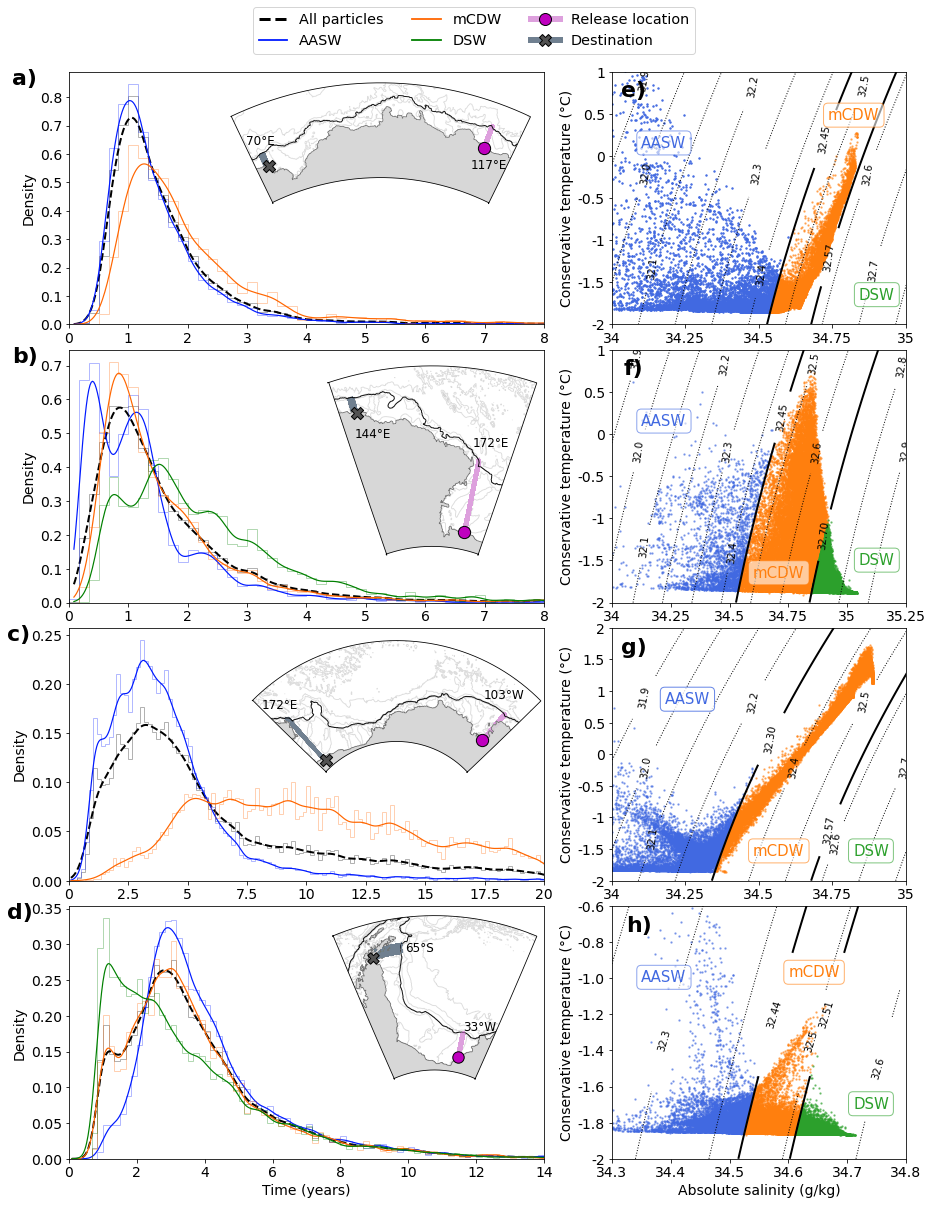

2022-10-14 14:03:03,024 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,082 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,085 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,125 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,226 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,244 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,333 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,336 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,341 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,420 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,646 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,648 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,688 - distributed.nanny - WARNING - Restarting worker
2022-10-14 14:03:03,722 - distributed.

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(15,20))
spec1 = gridspec.GridSpec(ncols=5, nrows=4, figure=fig)
ax1 = fig.add_subplot(spec1[0, 0:3], )
ax2 = fig.add_subplot(spec1[1, 0:3], )
ax3 = fig.add_subplot(spec1[2, 0:3], )
ax4 = fig.add_subplot(spec1[3, 0:3], )
ax5 = fig.add_subplot(spec1[0, 3:], )
ax6 = fig.add_subplot(spec1[1, 3:], )
ax7 = fig.add_subplot(spec1[2, 3:], )
ax8 = fig.add_subplot(spec1[3, 3:], )
plt.subplots_adjust(wspace=0.6, hspace=0.1)


# East Antarctica ----------------------------------------------------
startlon = -243
plot_ttds(ax1, eafiles, bins)
df = pd.read_csv(eafiles[3])
ax1.set_xlim([0,8])
df = pd.read_csv(eafiles[3])
axins = inset_axes(ax1, width="60%", height="80%", loc="upper right", 
                   bbox_to_anchor = (-0.05,0.25,1,0.8),
                   bbox_transform=ax1.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes,
                   axes_kwargs=dict(map_projection=ccrs.Stereographic(central_longitude=95,central_latitude=-67)))
lons = lonsgrid.sel(lon=slice(95-28, 95+28)).sel(lat=slice(-71, -63))
lats = latsgrid.sel(lon=slice(95-28, 95+28)).sel(lat=slice(-71, -63))
boundary_path = make_boundary_path(lons, lats)
axins.set_boundary(boundary_path, transform=ccrs.PlateCarree())
axins.contourf(xu_ocean, yu_ocean_lm, land_mask_masked.values, [0,1], zorder=2,colors='lightgrey', alpha=0.9, linewidths=1, transform = ccrs.PlateCarree())
axins.contour(xu_ocean, yu_ocean, land_mask.values, [0,1], zorder=2,colors='dimgrey', alpha=0.9, linewidths=0.8, transform = ccrs.PlateCarree())
axins.contour(xu_ocean, yu_ocean, shelf_mask.values, [0,1], zorder=2,colors='k', alpha=0.9, linewidths=1, transform = ccrs.PlateCarree())
cs = axins.contour(ht.xt_ocean, ht.yt_ocean, ht, [500, 2000, 3000, 4000], colors='gainsboro', alpha=1, zorder=1, linewidths=0.9, transform=ccrs.PlateCarree())
axins.set_extent([67, 120, -71, -63], crs=ccrs.PlateCarree())
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
axins.scatter(startlon, startlat,marker='o', s=150, c='m', edgecolors='k', zorder=3, transform=ccrs.PlateCarree())
axins.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(70, -68, marker='X', s=150, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
axins.text(116, startlat-2, u'117\u00B0E', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
axins.text(67.5, -65.6, u'70\u00B0E', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
# T-S plot
sigma1_low = 32.45
sigma1_high = 32.57
ax5.scatter(salt_ea.where(sig1_ea < sigma1_low), 
            temp_ea.where(sig1_ea < sigma1_low),
            color=c_b, s=sz, edgecolors=c3)
ax5.scatter(salt_ea.where((sig1_ea >= sigma1_low) & (sig1_ea < sigma1_high)), 
            temp_ea.where((sig1_ea >= sigma1_low) & (sig1_ea < sigma1_high)),
            color=c_o, s=sz)
cl = ax5.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                       [31.9, 32, 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8],colors='k',
                      linewidths=1, linestyles=':')
cl_thresh = ax5.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                      [sigma1_low, sigma1_high],colors='k',linewidths=2,)
ax5.clabel(cl, )
ax5.clabel(cl_thresh, )
ax5.set_xlim([34, 35])
ax5.set_ylim([-2, 1])
xticks = [34, 34.25, 34.5, 34.75, 35]
yticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1]
ax5.set_xticks(xticks)
ax5.set_xticklabels(xticks, fontsize=fs)
ax5.set_yticks(yticks)
ax5.set_yticklabels(yticks, fontsize=fs)
ax5.text(0.1, 0.7, 'AASW', color='royalblue', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='royalblue', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax5.transAxes)
ax5.text(0.735, 0.81, 'mCDW', color='tab:orange', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:orange', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax5.transAxes)
ax5.text(0.84, 0.1, 'DSW', color='tab:green', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:green', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax5.transAxes)
ax5.set_ylabel(u'Conservative temperature (\u00B0C)', fontsize=fs)



# Ross Sea -----------------------------------------------------------
startlon = -188
plot_ttds(ax2, rsfiles, bins)
ax2.set_xlim([0,8])
df = pd.read_csv(rsfiles[3])
axins = insert_map(ax2, 'Stereographic', "65%", "84%", -200, 20, -79, -64, bbox = (0.1,0.065,1,0.87))
axins.set_extent([-220, -180, -79, -64], crs=ccrs.PlateCarree())
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
axins.scatter(startlon, startlat,marker='o', s=150, c='m', edgecolors='k', zorder=3, transform=ccrs.PlateCarree())
axins.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(-216, -67.1, marker='X', s=150, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
axins.text(-190, -70.4, u'172\u00B0E', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
axins.text(142-360, -69, u'144\u00B0E', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
# T-S plot
sigma1_low = 32.45
sigma1_high = 32.7
ax6.scatter(salt_rs.where(sig1_rs < sigma1_low), 
            temp_rs.where(sig1_rs < sigma1_low),
            color=c_b, s=sz)
ax6.scatter(salt_rs.where((sig1_rs >= sigma1_low) & (sig1_rs < sigma1_high)), 
            temp_rs.where((sig1_rs >= sigma1_low) & (sig1_rs < sigma1_high)),
            color=c_o, s=sz)
ax6.scatter(salt_rs.where(sig1_rs >= sigma1_high), 
            temp_rs.where(sig1_rs >= sigma1_high),
            color=c_g, s=sz)
cl = ax6.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                       [31.9, 32, 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.8, 32.9],colors='k',
                      linewidths=1, linestyles=':')
cl_thresh = ax6.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                      [sigma1_low, sigma1_high],colors='k',linewidths=2,)
ax6.clabel(cl, )
ax6.clabel(cl_thresh, )
ax6.set_xlim([34, 35.25])
ax6.set_ylim([-2, 1])
xticks = [34, 34.25, 34.5, 34.75, 35, 35.25]
yticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1]
ax6.set_xticks(xticks)
ax6.set_xticklabels(xticks, fontsize=fs)
ax6.set_yticks(yticks)
ax6.set_yticklabels(yticks, fontsize=fs)
ax6.text(0.1, 0.7, 'AASW', color='royalblue', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='royalblue', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax6.transAxes)
ax6.text(0.48, 0.1, 'mCDW', color='tab:orange', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:orange', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax6.transAxes)
ax6.text(0.84, 0.15, 'DSW', color='tab:green', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:green', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax6.transAxes)
ax6.set_ylabel(u'Conservative temperature (\u00B0C)', fontsize=fs)



# West Antarctica ---------------------------------------------------------------------------------------------------------------
startlon = -103
plot_ttds(ax3, wafiles, bins)
ax3.set_xlim([0,20])
df = pd.read_csv(wafiles[3])
ax3.set_xlim([0,20])
ax3.set_xticks([0,2.5,5,7.5,10,12.5,15,17.5,20])
ax3.set_xticklabels([0,2.5,5,7.5,10,12.5,15,17.5,20])
axins = insert_map(ax3, 'Stereographic', "60%", "70%", -145, 48, -79, -67, bbox = (0,0.18,1,0.8))
axins.set_extent([-192, -98, -79, -67], crs=ccrs.PlateCarree())
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
axins.scatter(startlon, startlat,marker='o', s=150, c='m', edgecolors='k', zorder=3, transform=ccrs.PlateCarree())
axins.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=1, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(-188, -77.9, marker='X', s=150, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
axins.text(-112, -71, u'103\u00B0W', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
axins.text(-192.5, -68.5, u'172\u00B0E', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
# T-S plot
sigma1_low = 32.3
sigma1_high = 32.57
ax7.scatter(salt_wa.where(sig1_wa < sigma1_low), 
            temp_wa.where(sig1_wa < sigma1_low),
            color=c_b, s=sz)
ax7.scatter(salt_wa.where((sig1_wa >= sigma1_low) & (sig1_wa < sigma1_high)), 
            temp_wa.where((sig1_wa >= sigma1_low) & (sig1_wa < sigma1_high)),
            color=c_o, s=sz)
cl = ax7.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                       [31.9, 32, 32.1, 32.2, 32.4, 32.5, 32.6, 32.7, 32.8],colors='k',
                      linewidths=1, linestyles=':')
cl_thresh = ax7.contour(salt_mesh,temp_mesh,sigma1_for_contouring,
                      [sigma1_low, sigma1_high],colors='k',linewidths=2,)
ax7.clabel(cl, )
ax7.clabel(cl_thresh, )
ax7.set_xlim([34, 35])
ax7.set_ylim([-2, 2])
xticks = [34, 34.25, 34.5, 34.75, 35]
yticks = [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]
ax7.set_xticks(xticks)
ax7.set_xticklabels(xticks, fontsize=fs)
ax7.set_yticks(yticks)
ax7.set_yticklabels(yticks, fontsize=fs)
ax7.text(0.18, 0.7, 'AASW', color='royalblue', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='royalblue', alpha=0.8, zorder=6,boxstyle='round,pad=0.3'), 
        transform = ax7.transAxes)
ax7.text(0.48, 0.1, 'mCDW', color='tab:orange', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:orange', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax7.transAxes)
ax7.text(0.82, 0.1, 'DSW', color='tab:green', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:green', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax7.transAxes)
ax7.set_ylabel(u'Conservative temperature (\u00B0C)', fontsize=fs)



# Weddell Sea ---------------------------------------------------------------------------------------------------------------
startlon = -33
plot_ttds(ax4, wsfiles, bins)
ax4.set_xlim([0,14])
df = pd.read_csv(wsfiles[3])
axins = insert_map(ax4, 'Stereographic', "60%", "72%", -45, 25, -79, -61, bbox=(0.08,0.08,1,0.9))
idx = np.where(ref.lon == startlon)[0]
startlat = ref.lat[idx].min().values
axins.scatter(startlon, startlat,marker='o', s=130, c='m',  edgecolors='k',zorder=3, transform=ccrs.PlateCarree())
axins.scatter(ref.lon[idx], ref.lat[idx] ,marker='o', s=10, c=startcol,  zorder=2, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(df['lon'], df['lat'], marker='.', s=1, c=destcol, zorder=2, alpha=0.01, transform=ccrs.PlateCarree())
axins.scatter(-62, -65, marker='X', s=130, color=destxcol, edgecolor='k', zorder=3, transform=ccrs.PlateCarree())
axins.text(-33, -74, u'33\u00B0W', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
axins.text(-53, -65, u'65\u00B0S', fontweight='normal', fontsize=12, transform=ccrs.PlateCarree())
# T-S plot
sigma1_low = 32.44
sigma1_high = 32.51
ax8.scatter(salt_ws.where(sig1_ws < sigma1_low), 
            temp_ws.where(sig1_ws < sigma1_low),
            color=c_b, s=sz)
ax8.scatter(salt_ws.where((sig1_ws >= sigma1_low) & (sig1_ws < sigma1_high)), 
            temp_ws.where((sig1_ws >= sigma1_low) & (sig1_ws < sigma1_high)),
            color=c_o, s=sz)
ax8.scatter(salt_ws.where(sig1_ws >= sigma1_high), 
            temp_ws.where(sig1_ws >= sigma1_high),
            color=c_g, s=sz)
cl = ax8.contour(salt_mesh_ws,temp_mesh_ws,sigma1_for_contouring_ws,
                       [31.9, 32, 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8],colors='k',
                      linewidths=1, linestyles=':')
cl_thresh = ax8.contour(salt_mesh_ws,temp_mesh_ws,sigma1_for_contouring_ws,
                      [sigma1_low, sigma1_high],colors='k',linewidths=2,)
ax8.clabel(cl, )
ax8.clabel(cl_thresh, )
ax8.set_xlim([34.3, 34.8])
ax8.set_ylim([-2, -0.6])
xticks = [34.3, 34.4, 34.5,34.6, 34.7, 34.8]
yticks = [-2, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6]
ax8.set_xticks(xticks)
ax8.set_xticklabels(xticks, fontsize=fs)
ax8.set_yticks(yticks)
ax8.set_yticklabels(yticks, fontsize=fs)
ax8.set_xlabel('Absolute salinity (g/kg)', fontsize=fs)
ax8.text(0.1, 0.7, 'AASW', color='royalblue', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='royalblue', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax8.transAxes)
ax8.text(0.6, 0.72, 'mCDW', color='tab:orange', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:orange', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax8.transAxes)
ax8.text(0.82, 0.2, 'DSW', color='tab:green', fontsize=15,
        bbox=dict(facecolor='w', edgecolor='tab:green', alpha=0.6, boxstyle='round,pad=0.3'), 
        transform = ax8.transAxes)
ax8.set_ylabel(u'Conservative temperature (\u00B0C)', fontsize=fs)


# Add legend elements
plot_main_legend()

# plot subplot labels
fs2 = 22
ax1.text(-0.12, 0.95, subplot_labels[0], fontweight='bold', fontsize=fs2, transform=ax1.transAxes)
ax2.text(-0.12,0.95, subplot_labels[1], fontweight='bold', fontsize=fs2, transform=ax2.transAxes)
ax3.text(-0.13, 0.95, subplot_labels[2], fontweight='bold', fontsize=fs2, transform=ax3.transAxes)
ax4.text(-0.13,0.95, subplot_labels[3], fontweight='bold', fontsize=fs2, transform=ax4.transAxes)
ax5.text(0.03, 0.9, subplot_labels[4], fontweight='bold', fontsize=fs2, transform=ax5.transAxes)
ax6.text(0.04, 0.9, subplot_labels[5], fontweight='bold', fontsize=fs2, transform=ax6.transAxes)
ax7.text(0.03, 0.9, subplot_labels[6], fontweight='bold', fontsize=fs2, transform=ax7.transAxes)
ax8.text(0.05, 0.9, subplot_labels[7], fontweight='bold', fontsize=fs2, transform=ax8.transAxes)

# save to file
outdir = '/g/data/e14/hd4873/runs/parcels/output/AntConn/figures/for_publication/'
outfile = outdir + 'Fig10_T-S_and_timescales_by_watermass.jpg'
#fig.savefig(outfile, dpi=300, bbox_inches='tight')
